# Mass Flux Oscillation

 But why is a 92-minute oscillation in the cloud size distribution significant?

 I have examined the properties of the cloud field, and it appears that the total mass flux of the cloud field has a close relationship with the slope of the cloud size distribution. Here, I repeat the GP regression workflow from the previous notebook for mass flux.

In [1]:
# Set up local project directory path
from pathlib import Path
from tqdm.notebook import tqdm
import sys

project_src = Path('../src').resolve().as_posix()
sys.path.insert(0, project_src)

try:
    import lib.config
except Exception:
    raise Exception("Issue with dynamic import")

config = lib.config.read_config()
pwd = Path(config['pwd'])
case = Path(config['case'])

In [2]:
# Import modules needed for the rest of the notebook
import numpy as np
import xarray as xr
import pandas as pd

import sklearn.preprocessing as skl_prep
from statsmodels.nonparametric import smoothers_lowess as sl

# Pytorch + GP
import torch, gpytorch
from gpytorch.priors import NormalPrior, UniformPrior

In [3]:
import matplotlib as mpl
from matplotlib import pyplot as plt

import seaborn as sns

sns.set_context('notebook')
sns.set_style('ticks', 
    {
        'axes.grid': True, 
        'axes.linewidth': '1',
        'xtick.labelsize' : 12,
        'ytick.labelsize' : 12,
        'grid.color': '0.5',
        'grid.linestyle': u':',
        'legend.frameon': True,
    })
xkcd = sns.xkcd_rgb


rc_opt = {
    "figure.dpi": 300,
    "font.family": "serif",
    "font.size": 15,
    "text.usetex": True,
    'text.latex.preamble': r"\usepackage{libertine} \usepackage[libertine]{newtxmath}",
}
mpl.rcParams.update(rc_opt)

 Of course, we will be using the old BOMEX dataset with a simple swamp ocean. For the sake of this notebook, I will simply calculate the total mass flux per minute. Since the vertical profile of mass flux remains consistent, calculating the mean yields the same result.

In [4]:
p = Path("/scratchSSD/loh/CGILS_S6/CGILS_1728x576x192_25m_1s_ent.nc")
df = xr.open_dataset(p)
df.MFTETCOR

<xarray.DataArray 'MFTETCOR' (time: 2880, z: 192)>
[552960 values with dtype=float32]
Coordinates:
  * z        (z) float32 12.5 37.5 62.5 87.5 ... 4.738e+03 4.762e+03 4.788e+03
  * time     (time) float32 196.0 196.0 196.0 196.0 ... 198.0 198.0 198.0 198.0
Attributes:
    long_name:  Tetrahedral Core Vertical Mass Flux
    units:      kg/m2/s

In [5]:
y = np.array(np.nanmean(df.MFTETCOR.T, axis=0)[1440:])
x = np.arange(len(y))

x_full = torch.tensor(x[:720], dtype=torch.double)
y_full = torch.tensor(y[:720], dtype=torch.double)

x_tr = torch.tensor(x[:720], dtype=torch.double)
y_tr = torch.tensor(y[:720], dtype=torch.double)

 The following plot shows the timeseries of total mass flux. Again, it looks very noisy and the oscillatory behaviour is not evident at all. The workflow remains exactly the same as the cloud size distribution, so I will skip the comments.

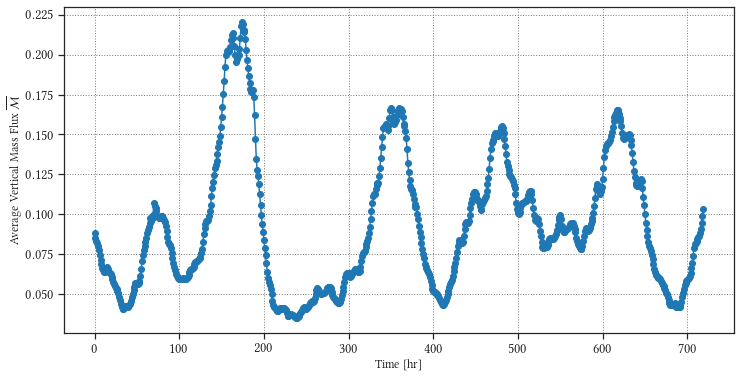

In [6]:
# Plot
fig, ax = plt.subplots(1, 1, figsize = (12, 6))
ax.plot(x_full, y_full, 'o-')

ax.set_xlabel("Time [hr]")
ax.set_ylabel("Average Vertical Mass Flux $\overline{\mathcal{M}}$")

ax.tick_params(axis="both", which="major", labelsize=14)

In [7]:
class SmoothGPModel(gpytorch.models.ExactGP):
    def __init__(self, x_tr, y_tr, likelihood):
        super(SmoothGPModel, self).__init__(x_tr, y_tr, likelihood)
        
        self.mean_module = gpytorch.means.ConstantMean()
        
        self.cov_module = gpytorch.kernels.AdditiveKernel(
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()),
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel()),
        )

    def forward(self, x):
        x_mean = self.mean_module(x)
        x_cov = self.cov_module(x)
        
        return gpytorch.distributions.MultivariateNormal(x_mean, x_cov)

In [8]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint = gpytorch.constraints.GreaterThan(1.e-4)
)
model = SmoothGPModel(x_tr, y_tr, likelihood)

# Initialize kernels
model.cov_module.kernels[0].base_kernel.initialize(
    lengthscale = torch.tensor(50.)
)

model.cov_module.kernels[1].base_kernel.initialize(
    lengthscale = torch.tensor(50.),
    period_length = torch.tensor(95.),
)

model.double()

SmoothGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (cov_module): AdditiveKernel(
    (kernels): ModuleList(
      (0): ScaleKernel(
        (base_kernel): RBFKernel(
          (raw_lengthscale_constraint): Positive()
        )
        (raw_outputscale_constraint): Positive()
      )
      (1): ScaleKernel(
        (base_kernel): PeriodicKernel(
          (raw_lengthscale_constraint): Positive()
          (raw_period_length_constraint): Positive()
        )
        (raw_outputscale_constraint): Positive()
      )
    )
  )
)

In [9]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([{'params': model.parameters()},], lr=1e-1)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

max_iter = 200
losses = []

p_bar = tqdm(range(max_iter))
for i in p_bar:
    optimizer.zero_grad()
    output = model(x_tr)
    loss = -mll(output, y_tr)
    losses += [loss.item()]
    loss.backward()

    p_status = f"{i + 1:3d}/{max_iter:3d} Loss: {loss.item():.3f}"
    p_bar.set_description(p_status)
    
    optimizer.step()

  0%|          | 0/200 [00:00<?, ?it/s]

/tera/users/loh/.local/conda/envs/stats/lib/python3.9/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:130: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1647804203612/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1666.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


In [10]:
# Model parameters
for param_name, param in model.named_parameters():
    print(f"{param_name:42} \t {param.item()}")

likelihood.noise_covar.raw_noise           	 -11.690095759879876
mean_module.constant                       	 0.10531517582301506
cov_module.kernels.0.raw_outputscale       	 -5.191402664586598
cov_module.kernels.0.base_kernel.raw_lengthscale 	 32.597796997519985
cov_module.kernels.1.raw_outputscale       	 -4.838498032055976
cov_module.kernels.1.base_kernel.raw_lengthscale 	 36.39588726702947
cov_module.kernels.1.base_kernel.raw_period_length 	 88.57060275654507


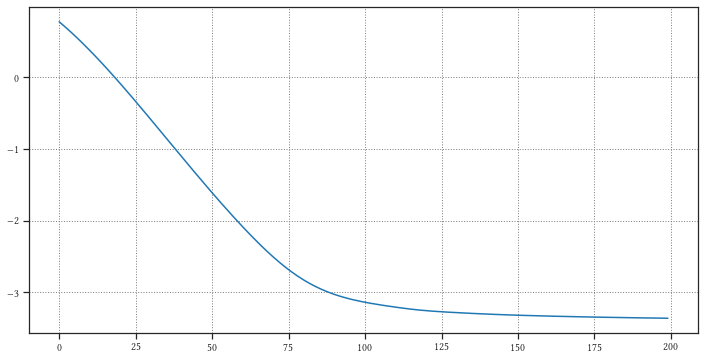

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(np.arange(len(losses)), losses)

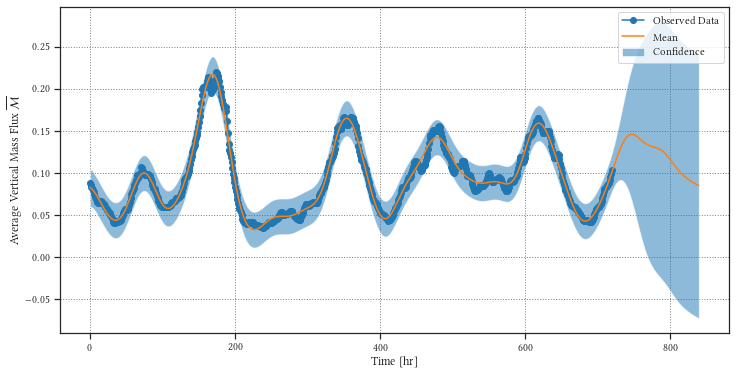

In [12]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

offset = 120

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad():
    x_test = torch.arange(len(x_tr)+120, dtype=torch.double)
    observed = likelihood(model(x_test))

with torch.no_grad():
    # Initialize plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))

    lower, upper = observed.confidence_region()
    
    ax.plot(x_tr.numpy(), y_tr.numpy(), 'o-')
    ax.plot(x_test.numpy(), observed.mean.numpy())
    ax.fill_between(x_test.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)

    ax.set_xlabel("Time [hr]")
    ax.set_ylabel("Average Vertical Mass Flux $\overline{\mathcal{M}}$")

    ax.legend(['Observed Data', 'Mean', 'Confidence'])

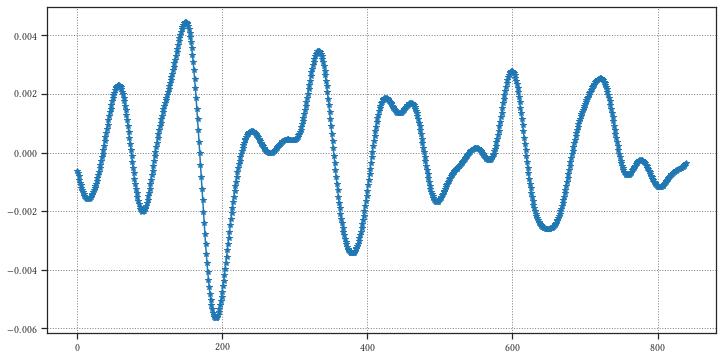

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(x_test.numpy(), np.gradient(observed.mean.numpy()), '*-')

y_tr = torch.tensor(np.gradient(observed.mean)[:-offset], dtype=torch.double)
x_tr = torch.tensor(np.arange(len(y_tr)), dtype=torch.double)

In [14]:
class PeriodicGPModel(gpytorch.models.ExactGP):
    def __init__(self, x_tr, y_tr, likelihood):
        super(PeriodicGPModel, self).__init__(x_tr, y_tr, likelihood)
        
        self.mean_module = gpytorch.means.ZeroMean()
        
        self.cov_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.PeriodicKernel()
        )

    def forward(self, x):
        x_mean = self.mean_module(x)
        x_cov = self.cov_module(x)
        
        return gpytorch.distributions.MultivariateNormal(x_mean, x_cov)

In [15]:
# Initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint = gpytorch.constraints.Positive(),
    noise_prior = gpytorch.priors.NormalPrior(1e-4, 1e-2),
)
model = PeriodicGPModel(x_tr, y_tr, likelihood)

model.cov_module.base_kernel.initialize(
    period_length = torch.tensor(95.),
)

model.double()

PeriodicGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): NormalPrior()
      (raw_noise_constraint): Positive()
    )
  )
  (mean_module): ZeroMean()
  (cov_module): ScaleKernel(
    (base_kernel): PeriodicKernel(
      (raw_lengthscale_constraint): Positive()
      (raw_period_length_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

In [16]:
# Model parameters
for param_name, param in model.named_parameters():
    print(f"{param_name:48} \t {param.item()}")
    
print(f"\n {model.cov_module.base_kernel}")

likelihood.noise_covar.raw_noise                 	 0.0
cov_module.raw_outputscale                       	 0.0
cov_module.base_kernel.raw_lengthscale           	 0.0
cov_module.base_kernel.raw_period_length         	 95.0

 PeriodicKernel(
  (raw_lengthscale_constraint): Positive()
  (raw_period_length_constraint): Positive()
)


 And I wish I had access to CUDA cores.

In [17]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([{'params': model.parameters()},], lr=1e-1)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

max_iter = int(4e2)
losses = []

p_bar = tqdm(range(max_iter))
for i in p_bar:
    optimizer.zero_grad()
    output = model(x_tr)
    loss = -mll(output, y_tr)
    losses += [loss.item()]
    loss.backward()

    period = model.cov_module.base_kernel.raw_period_length.item()

    p_status = f"{i + 1:3d}/{max_iter:3d} Loss: {loss.item():.3f} Period: {period:.3f}"
    p_bar.set_description(p_status)
    
    optimizer.step()

  0%|          | 0/400 [00:00<?, ?it/s]

In [18]:
# Model parameters
for param_name, param in model.named_parameters():
    print(f"{param_name:42} \t {param.item()}")

likelihood.noise_covar.raw_noise           	 -12.955477969750277
cov_module.raw_outputscale                 	 -12.147775347025194
cov_module.base_kernel.raw_lengthscale     	 5.734714317329387
cov_module.base_kernel.raw_period_length   	 92.5107446914862


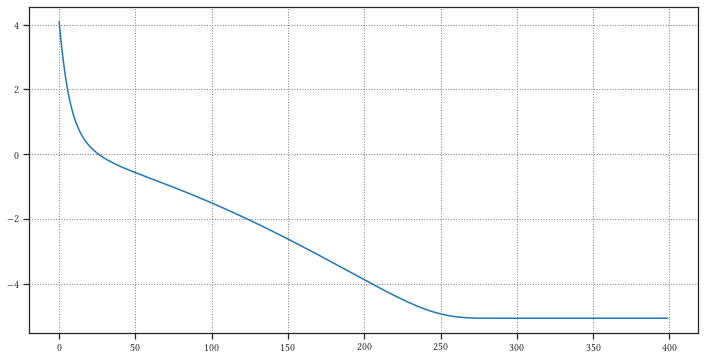

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(np.arange(len(losses)), losses)

In [20]:
print(mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): NormalPrior()
      (raw_noise_constraint): Positive()
    )
  )
  (model): PeriodicGPModel(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): NormalPrior()
        (raw_noise_constraint): Positive()
      )
    )
    (mean_module): ZeroMean()
    (cov_module): ScaleKernel(
      (base_kernel): PeriodicKernel(
        (raw_lengthscale_constraint): Positive()
        (raw_period_length_constraint): Positive()
        (distance_module): Distance()
      )
      (raw_outputscale_constraint): Positive()
    )
  )
)


In [21]:
dt = 180

# Make predictions by feeding model through likelihood
x_test = torch.arange(x_tr.size(dim=0) + dt, dtype=torch.double)

model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed = likelihood(model(x_test))
    y_mean = observed.mean
    lower, upper = observed.confidence_region()

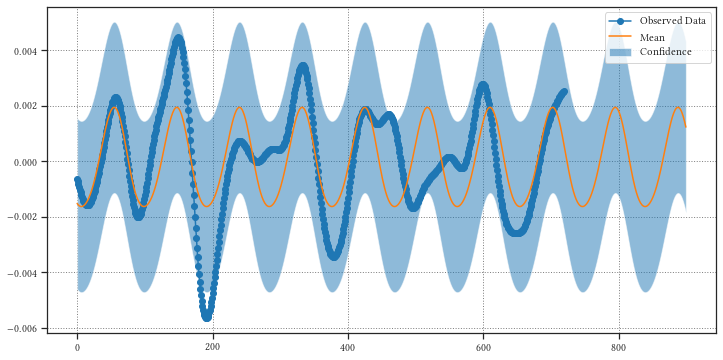

In [22]:
with torch.no_grad():
    # Initialize plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))

    lower, upper = observed.confidence_region()
    
    ax.plot(x_tr.numpy(), y_tr.numpy(), 'o-')
    ax.plot(x_test, y_mean)
    ax.fill_between(x_test.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

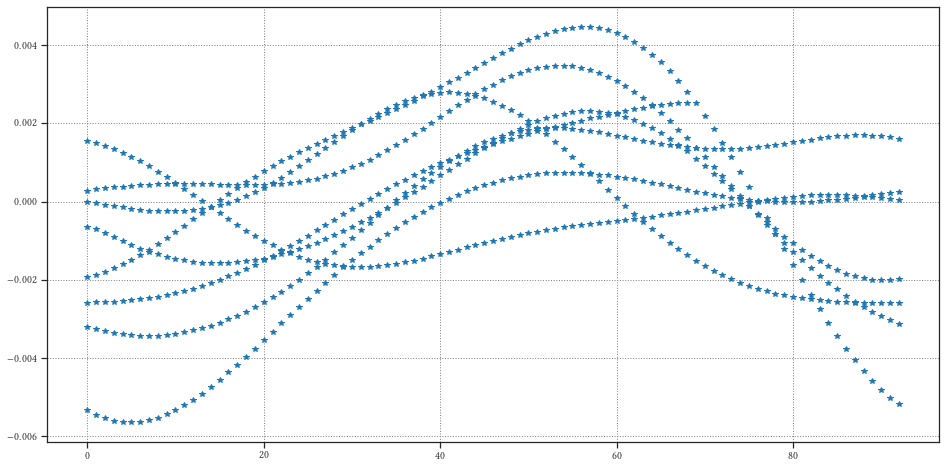

In [23]:
# Redefine training domain
x_tr_rep = np.mod(x_tr, 93)

# Plot
fig, ax = plt.subplots(1, 1, figsize = (16, 8))
ax.plot(x_tr_rep, y_tr, '*')

 At this point it is a little disturbing. Total mass flux across the cloud field is a *better* indicator of oscillatory growth of cloud field! All I had to do was to add everything up and make a timeseries out of it. 
 
 Still, it is nice that we have confirmed this is the case. We did come to this conclusion backwards, but the main point is that the transition between the two phases of cloud growth can be directly related to a quantifiable meaure.

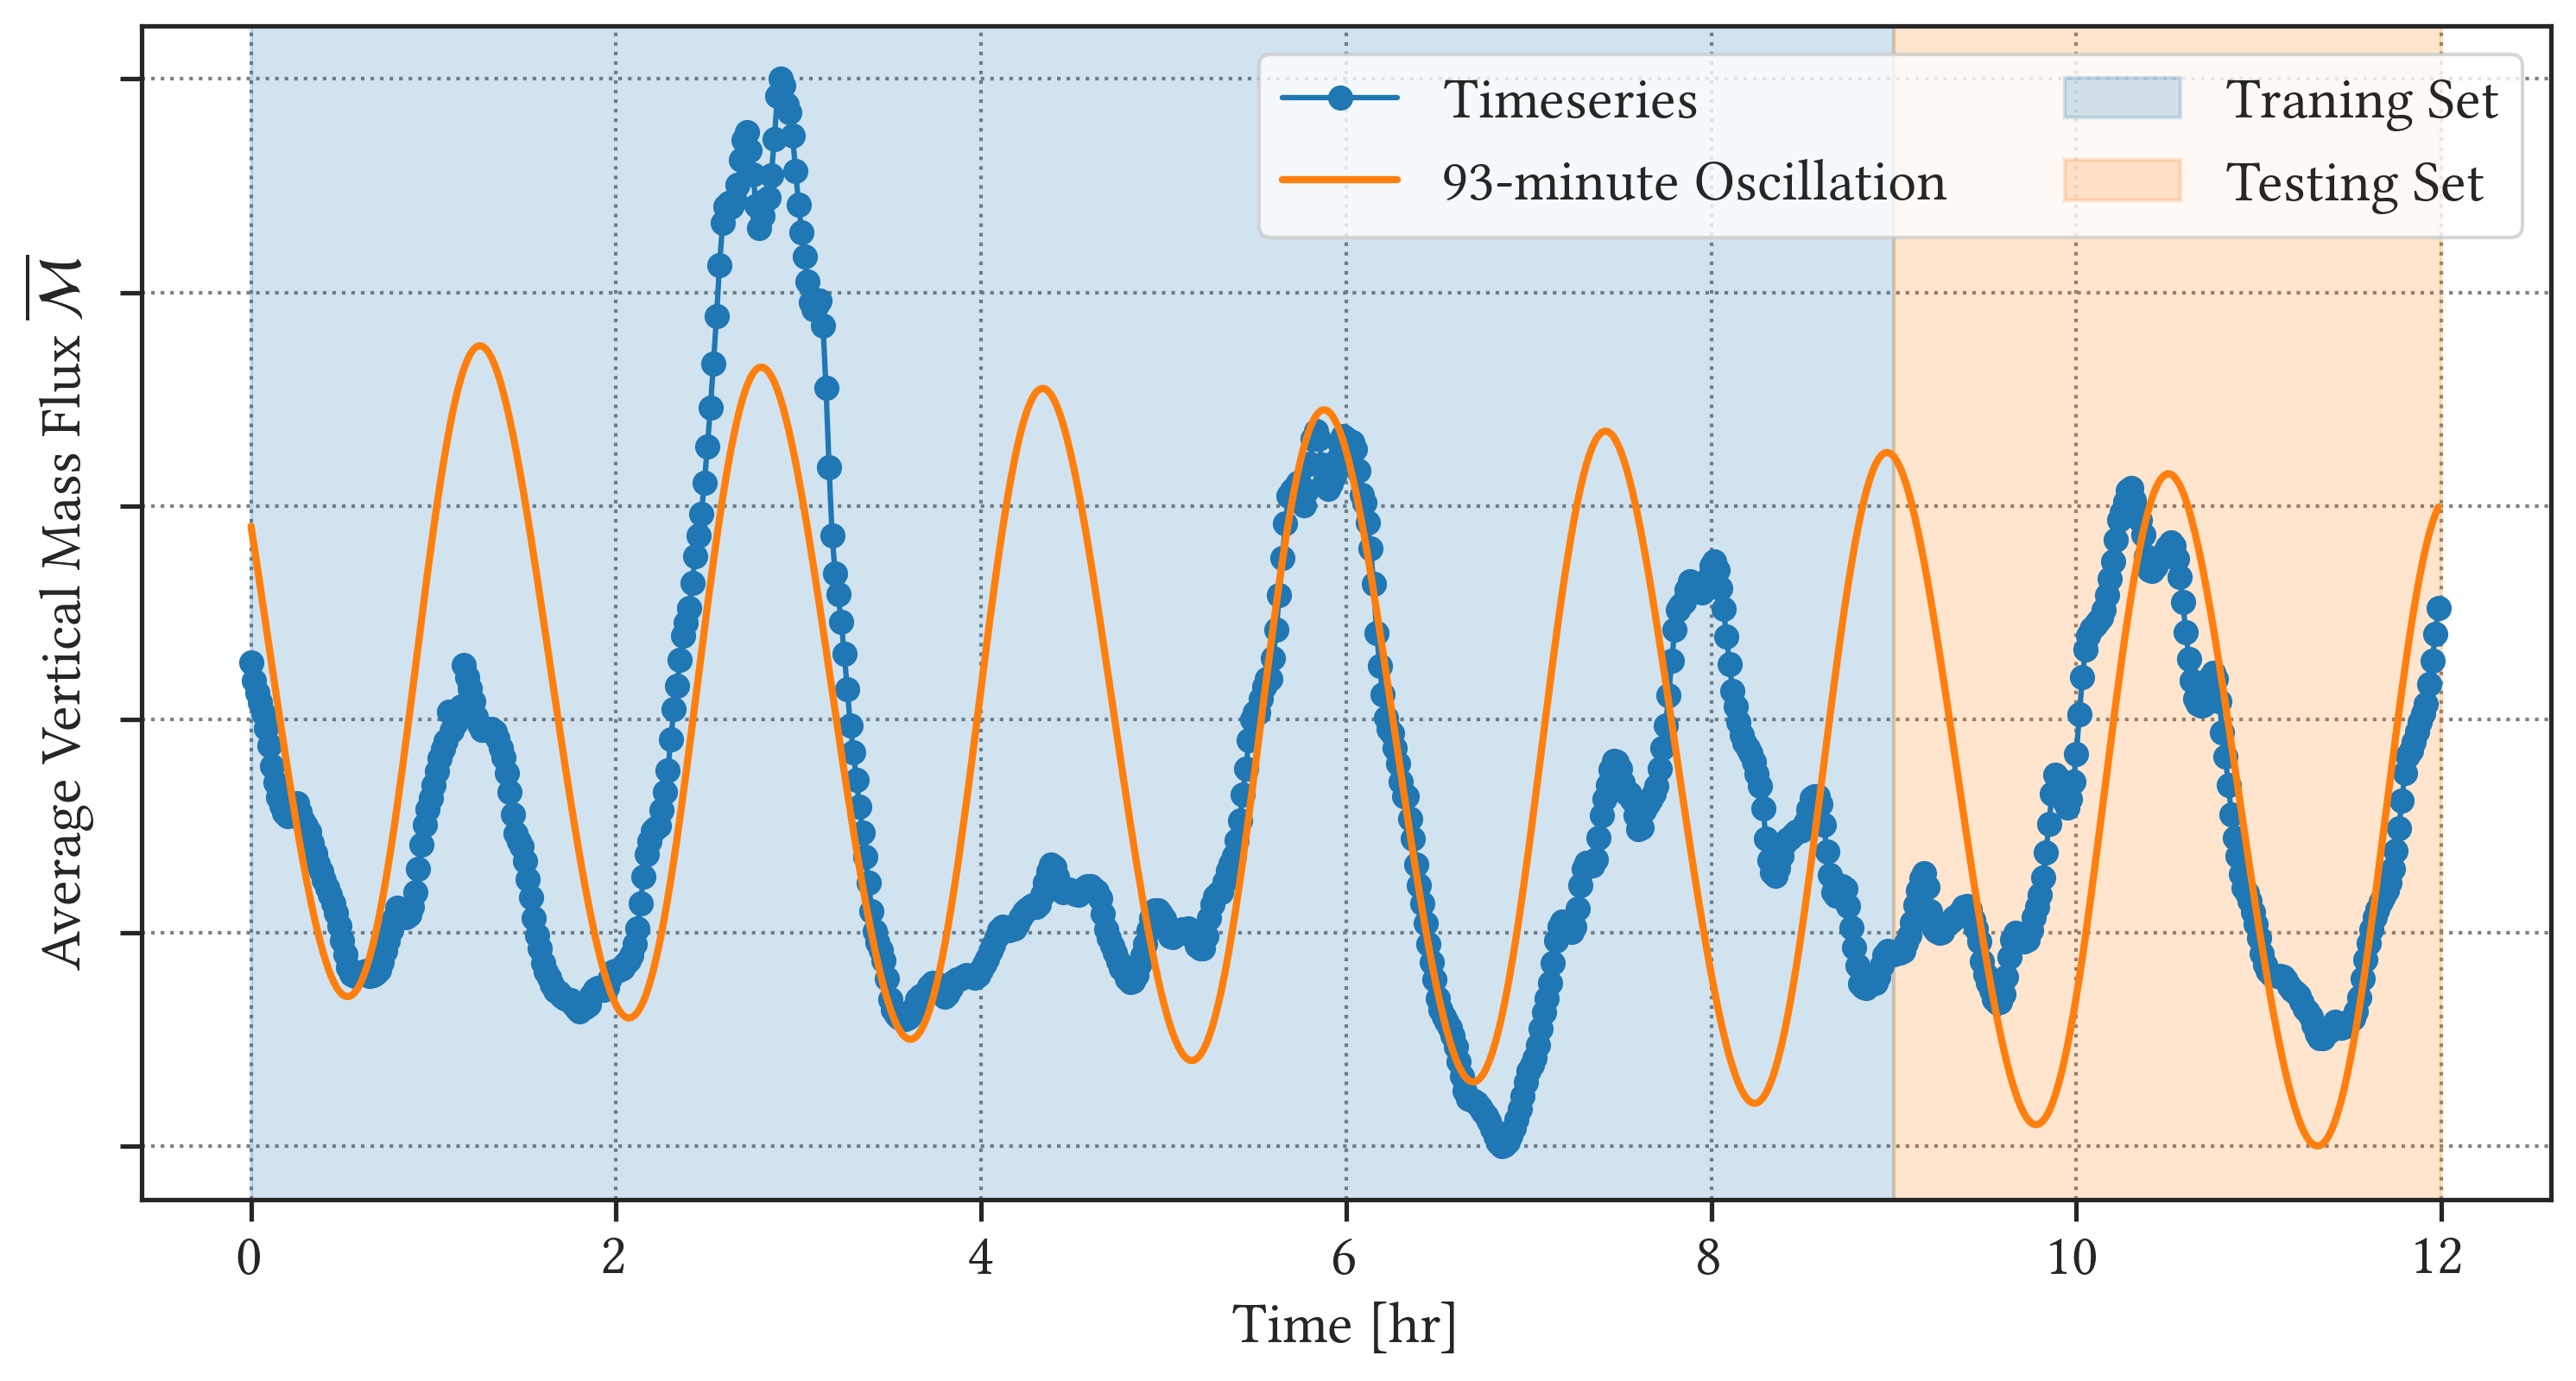

In [24]:
y_pr = y_mean.numpy()[:720]
y_pr = np.cumsum(y_pr - np.mean(y_pr, axis=0))

y_sl = y_full[:720] - sl.lowess(y_full[:720], x_full[:720], return_sorted=False, frac=0.3)

x_c = np.arange(len(y_pr)) / 60

# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=300)

ax.plot(x_c,
    skl_prep.minmax_scale(y_sl[:, None], axis=0),
    "o-",
    label="Timeseries")
ax.plot(
    x_c,
    skl_prep.minmax_scale(y_pr[:, None], axis=0) * 0.75,
    "-",
    lw=2,
    label="93-minute Oscillation",
)

ax.axvspan(0, 9, alpha=0.2, color="C0", label="Traning Set")
ax.axvspan(9, 12, alpha=0.2, color="C1", label="Testing Set")

ax.legend(loc=0, ncol=2, frameon=True, fontsize=16)

ax.set_yticklabels([])

ax.set_xlabel("Time [hr]", fontsize=16)
ax.set_ylabel("Average Vertical Mass Flux $\overline{\mathcal{M}}$", fontsize=16)

ax.tick_params(axis="both", which="major", labelsize=16)

 It is, then, not surprising to see that the slope of the cloud size distribution and total mass flux are closely related. What is surprising, and perhaps more important, is that it is also very closely related to cloud cover. That is, total cloud cover over a domain also oscillates with total mass flux and the cloud size distribution. I won't repeat the GP regression for cloud cover, because it will be exactly same as this one.

 Given the result, one cloud look at the cloud cover over time and infer the strength of mass flux (and naturally, entrainment) over the cloud field. Also, we can perform a GP regression in 2-dimensional (height, time) space using the vertial mass flux (or entrainment) profile. Because both mass flux entrainment appear to oscillate with a 92-minute period while maintaining the general shape of the vertical profile, it means that the uncertainty involved in calculating the mean vertical mass flux and entrainment profiles will be a lot smaller once we account for the the oscillation.

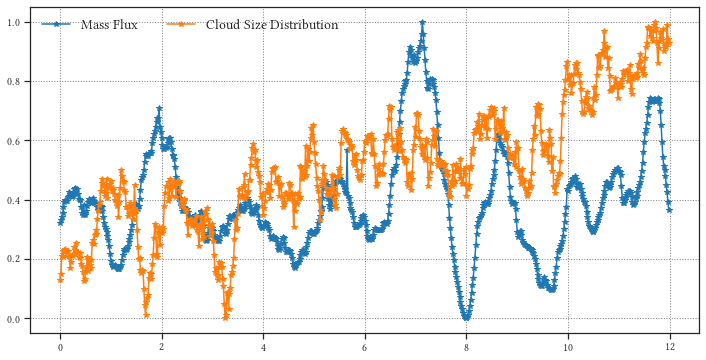

In [25]:
df = xr.open_dataset(p)

y_mf = np.array(np.nanmean(df.MFTETCOR.T, axis=0)[720:])

p = Path('../output/slope_BOMEX_SWAMP_COR_KDE_PIECEWISE.pq')
ds = pd.read_parquet(p)

y_sl = ds.slope.to_numpy()

x_c = np.arange(len(y_sl)) / 60

# Plot
fig, ax = plt.subplots(1, 1, figsize = (12, 6))

ax.plot(x_c, skl_prep.minmax_scale(y_mf[:720, None], axis=0), '*-', label='Mass Flux')
ax.plot(x_c, skl_prep.minmax_scale(-y_sl[:720, None], axis=0), '*-', label='Cloud Size Distribution')

ax.legend(loc=0, ncol=2, frameon=False, fontsize=14)

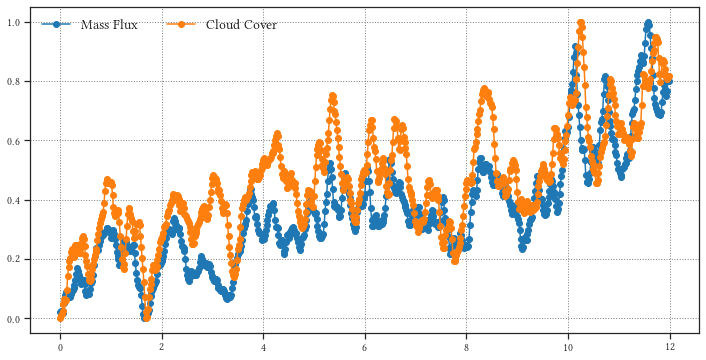

In [26]:
p = Path(f'{case}/../BOMEX_SWAMP/BOMEX_1536x512x128_25m_1s_ent_ocean_50m.nc')
df = xr.open_dataset(p)

y_mf = np.array(np.nanmean(df.MFTETCOR.T, axis=0)[720:])

y_cld = np.array(df.CLDSHD[720:])

x_c = np.arange(len(y_cld)) / 60

# Plot
fig, ax = plt.subplots(1, 1, figsize = (12, 6))

ax.plot(x_c, skl_prep.minmax_scale(y_mf[:720, None], axis=0), 'o-', label='Mass Flux')
ax.plot(x_c, skl_prep.minmax_scale(y_cld[:720, None], axis=0), 'o-', label='Cloud Cover')

ax.legend(loc=0, ncol=2, frameon=False, fontsize=14)